In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt

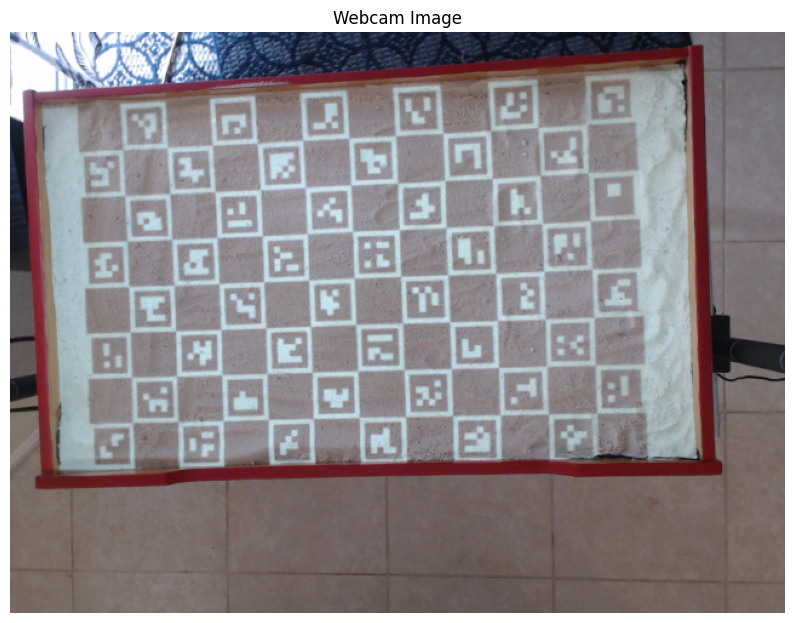

In [18]:
# Capture webcam view while projecting via board-test.py script
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

board_image_path = 'Downloads/board.jpg'
cv2.imwrite(board_image_path, frame)

plt.figure(figsize=(10, 10))
plt.title('Webcam Image')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [40]:
# Load the image, used for subsequent runs through this logic to avoid
# webcam need
image_path = 'Downloads/board.jpg'
frame = cv2.imread(image_path)

plt.figure(figsize=(10, 10))
plt.title('Webcam Image')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

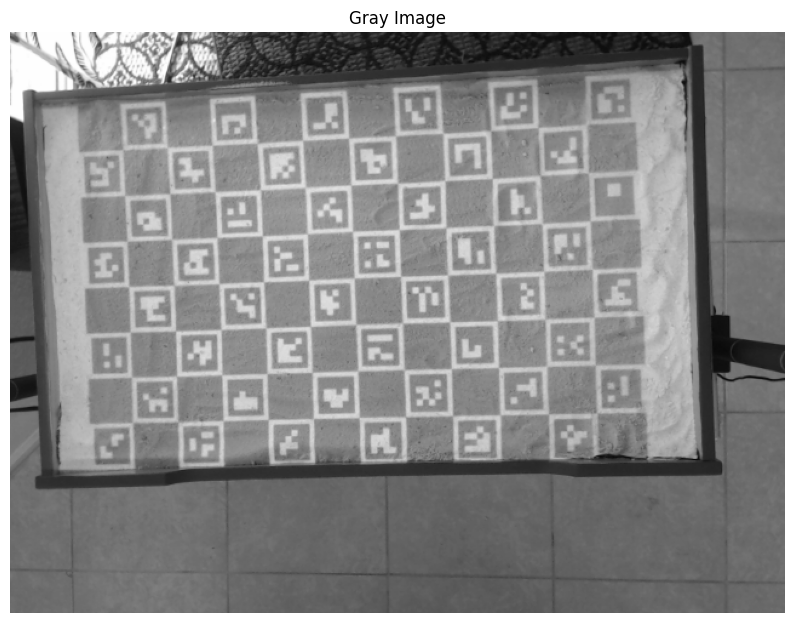

In [23]:
# CharucoBoard configuration
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
board = cv2.aruco.CharucoBoard((12, 8), 0.015, 0.012, aruco_dict)

detection_params = cv2.aruco.DetectorParameters()
detection_params.cornerRefinementMethod = cv2.aruco.CORNER_REFINE_NONE

# Grayscale version of webcam image frame
image_grayscale = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 10))
plt.title('Gray Image')
plt.imshow(cv2.cvtColor(image_grayscale, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

CHARUCO corners detected: 73
CHARUCO ids detected: 73


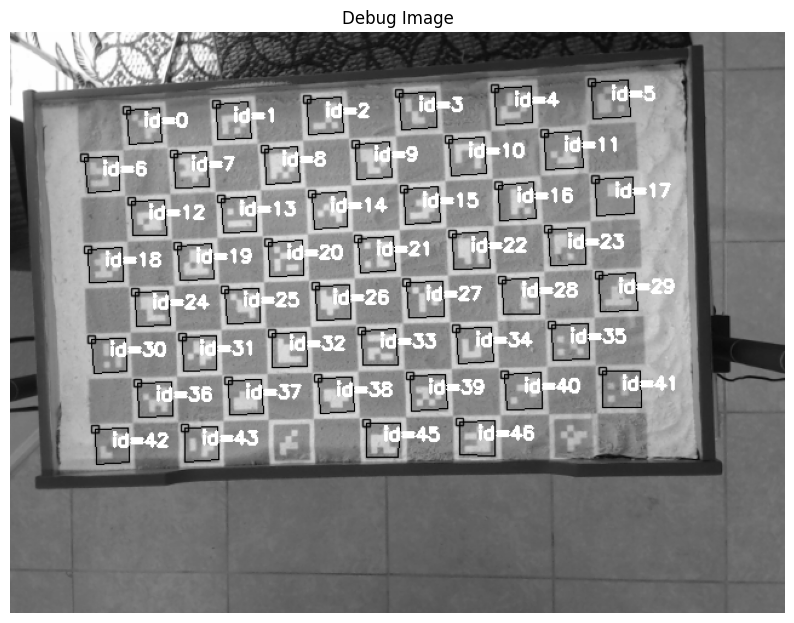

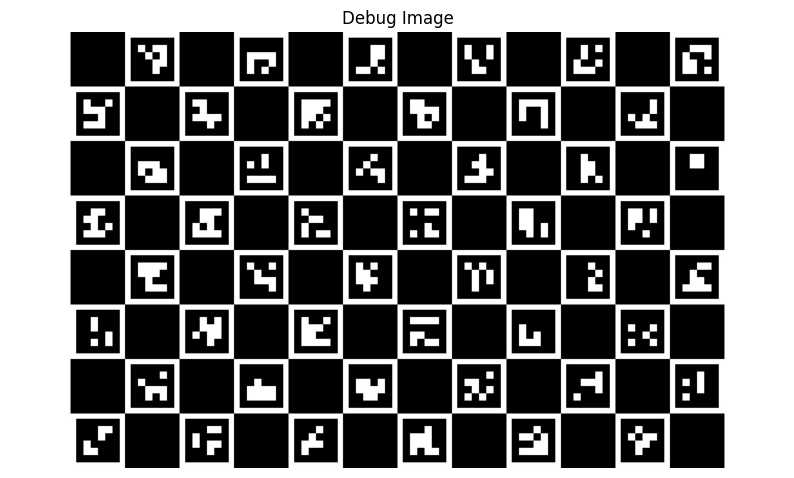

CHARUCO corners detected: 77
CHARUCO ids detected: 77


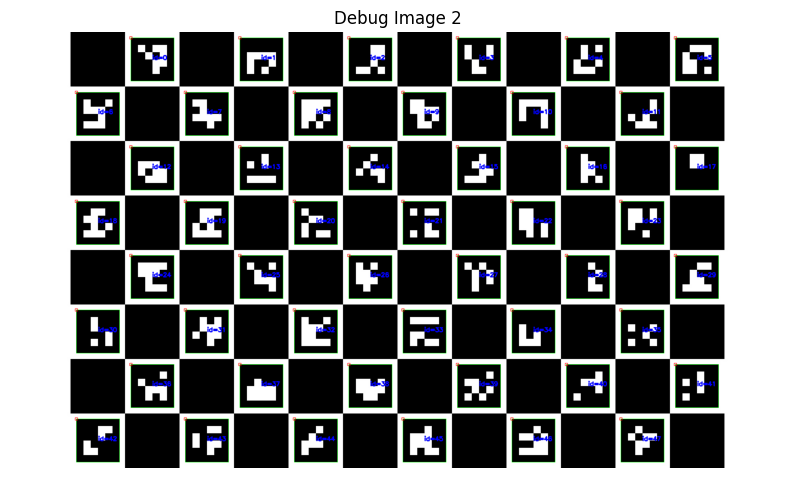

Filtered CHARUCO corners: 73
Filtered CHARUCO ids: 73


In [24]:
# Get charuco corners for grayscale calibration webcam image
charucodetector = cv2.aruco.CharucoDetector(board, detectorParams=detection_params)
charuco_corners, charuco_ids, marker_corners, marker_ids = charucodetector.detectBoard(image_grayscale)
print("CHARUCO corners detected:", len(charuco_corners) if charuco_corners is not None else 0)
print("CHARUCO ids detected:", len(charuco_ids) if charuco_ids is not None else 0)

# Draw markers on grayscale version of captured image
debug_image = cv2.aruco.drawDetectedMarkers(image_grayscale, marker_corners, marker_ids, borderColor=(0, 255, 0))
plt.figure(figsize=(10, 10))
plt.title('Debug Image')
plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Render board projection
board_projection_path = 'Downloads/board-projection.jpg'
board_projection = cv2.imread(board_projection_path)
plt.figure(figsize=(10, 10))
plt.title('Debug Image')
plt.imshow(cv2.cvtColor(board_projection, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Determine corners from board projection
base_charuco_corners, base_charuco_ids, base_marker_corners, base_marker_ids = charucodetector.detectBoard(board_projection)
print("CHARUCO corners detected:", len(base_charuco_corners) if base_charuco_corners is not None else 0)
print("CHARUCO ids detected:", len(base_charuco_ids) if base_charuco_ids is not None else 0)

# With detected markers on board projection
debug_image2 = cv2.aruco.drawDetectedMarkers(board_projection, base_marker_corners, base_marker_ids, borderColor=(0, 255, 0))
plt.figure(figsize=(10, 10))
plt.title('Debug Image 2')
plt.imshow(cv2.cvtColor(debug_image2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Filtered charuco corners as some may be distorted from the sand
if base_charuco_ids is not None and charuco_ids is not None:
    filtered_corners = []
    filtered_ids = []
    original_ids_set = set(charuco_ids.flatten())

    for i, base_id in enumerate(base_charuco_ids.flatten()):
        if base_id in original_ids_set:
            filtered_corners.append(base_charuco_corners[i])
            filtered_ids.append(base_id)

    filtered_corners = np.array(filtered_corners)
    filtered_ids = np.array(filtered_ids)

    print("Filtered CHARUCO corners:", len(filtered_corners))
    print("Filtered CHARUCO ids:", len(filtered_ids))


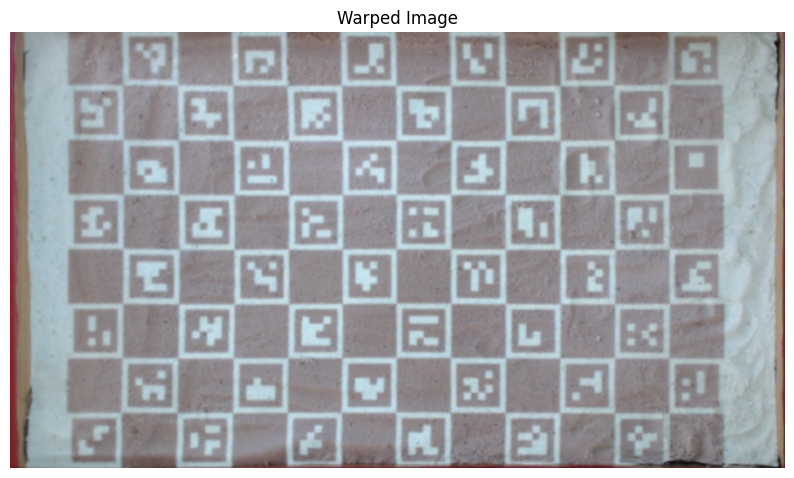

In [25]:
# Find homography for warping image
src_pts = charuco_corners.reshape(-1, 2).astype(np.float32)
dst_pts = filtered_corners.reshape(-1, 2).astype(np.float32)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
height, width = board_projection.shape[:2]
warped_image = cv2.warpPerspective(frame, H, (width, height))

plt.figure(figsize=(10, 10))
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

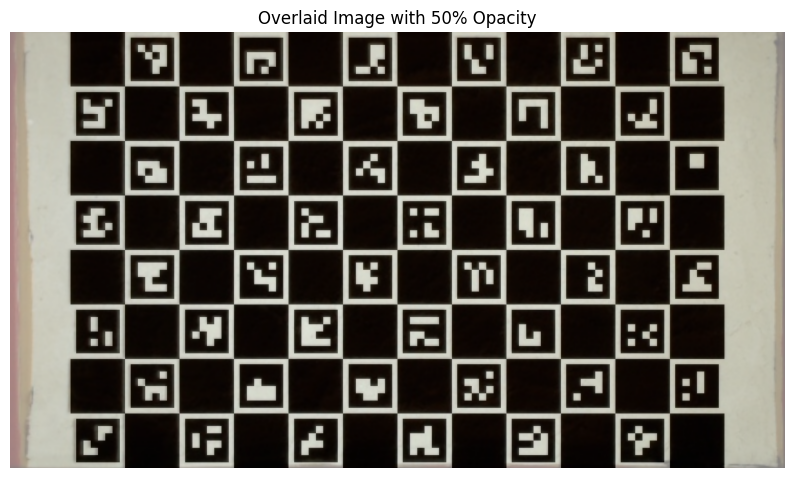

In [11]:
# Sanity check, blend warped image with projected image
import cv2
import numpy as np
import matplotlib.pyplot as plt

board_projection = cv2.imread(board_projection_path)

height, width = warped_image.shape[:2]
board_projection_resized = cv2.resize(board_projection, (width, height))

# Blend images and display
alpha = 0.5
blended_image = cv2.addWeighted(warped_image, alpha, board_projection_resized, 1 - alpha, 0)
blended_image_rgb = cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.title('Overlaid Image with 50% Opacity')
plt.imshow(blended_image_rgb)
plt.axis('off')
plt.show()


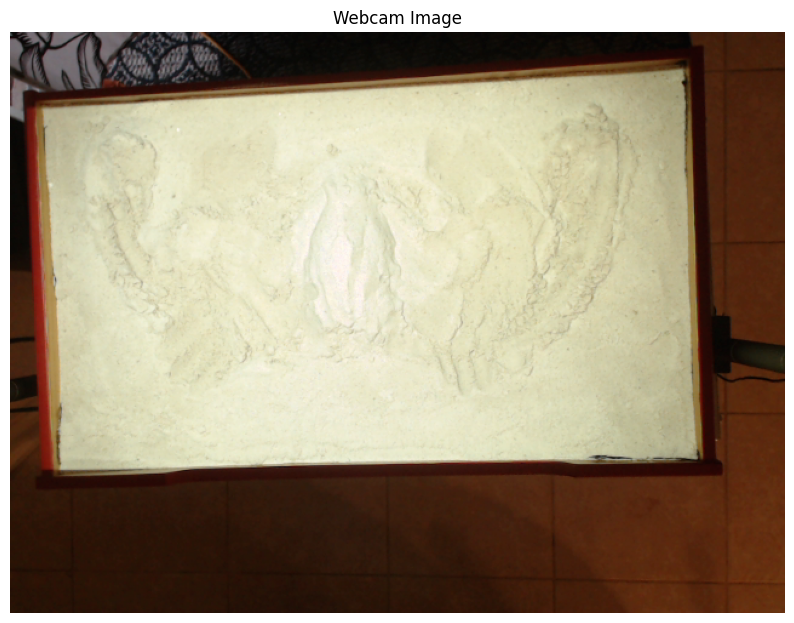

In [13]:
# Capture of webcam with sand distorted post calibration
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

board_image_path = 'Downloads/depth-test.jpg'
cv2.imwrite(board_image_path, frame)

plt.figure(figsize=(10, 10))
plt.title('Webcam Image')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

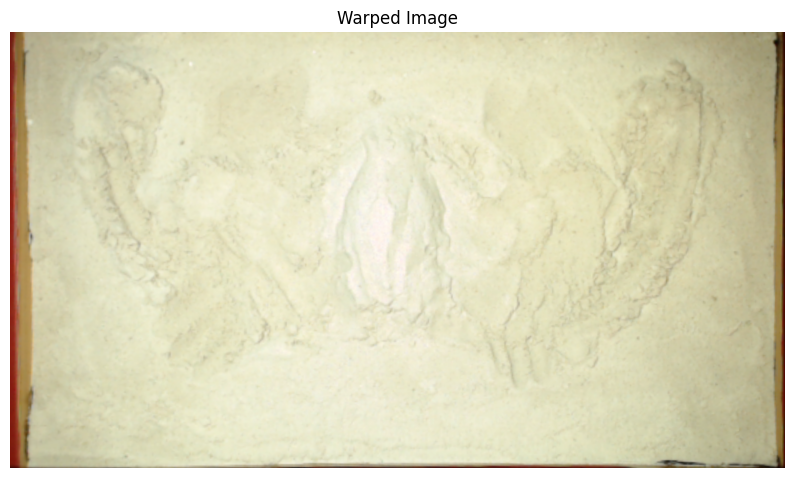

True

In [16]:
# Warped image for use with Depth-Anything-V2
height, width = board_projection.shape[:2]
warped_image = cv2.warpPerspective(frame, H, (width, height))

plt.figure(figsize=(10, 10))
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

board_image_path = 'Downloads/depth-test-focus.jpg'
cv2.imwrite(board_image_path, warped_image)

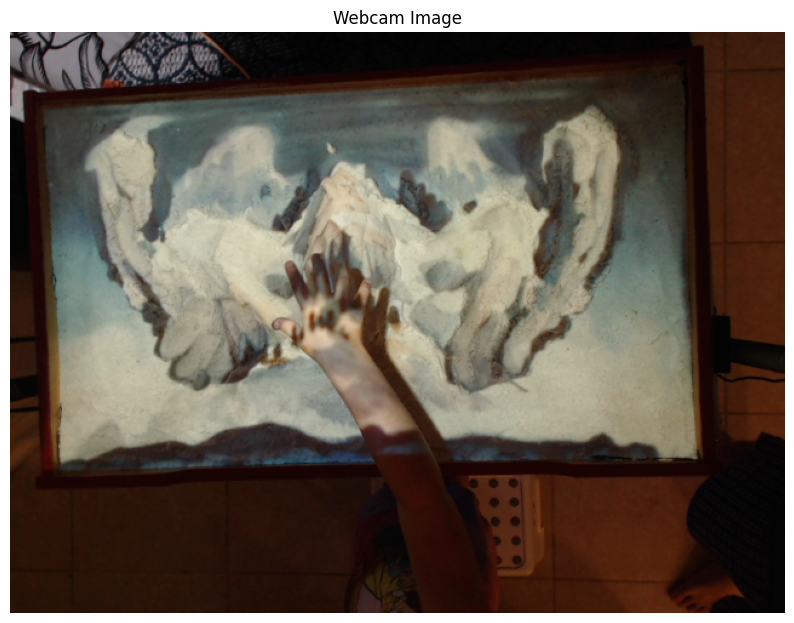

In [18]:
# Webcam photo of hand over sandbox for testing hand logic
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()

board_image_path = 'Downloads/hands-test.jpg'
cv2.imwrite(board_image_path, frame)

plt.figure(figsize=(10, 10))
plt.title('Webcam Image')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [39]:
# Utilizing the warp perspective logic to isolate to the board's dimension / contents
height, width = board_projection.shape[:2]
warped_image = cv2.warpPerspective(frame, H, (width, height))

plt.figure(figsize=(10, 10))
plt.title('Warped Image')
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

board_image_path = 'Downloads/depth-test-focus.jpg'
cv2.imwrite(board_image_path, warped_image)

True

In [20]:
# Hand checking logic
def check_for_hands(image, mp_hands) -> bool:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    results = mp_hands.process(image_rgb)
    if results.multi_hand_landmarks:
        return True
    else:
        return False

mp_hands = mp.solutions.hands.Hands()

if check_for_hands(warped_image, mp_hands):
    print("Hands found")
else:
    print("No hands found")


Hands found


W0000 00:00:1722424570.530881   10043 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1722424570.537367   10054 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [29]:
# TTS logic, not utilized in the end project as we ran out of time
import torch
from TTS.api import TTS

# Get device
device = "cuda"

tts_manager = TTS().list_models()
all_models = tts_manager.list_models()
print(all_models)

tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2").to(device)
tts.tts_to_file(text="The brown fox goes to New York.", speaker_wav="/home/nineso/Downloads/aaron.wav", language="en", file_path="/home/nineso/Downloads/output.wav")

['tts_models/multilingual/multi-dataset/xtts_v2', 'tts_models/multilingual/multi-dataset/xtts_v1.1', 'tts_models/multilingual/multi-dataset/your_tts', 'tts_models/multilingual/multi-dataset/bark', 'tts_models/bg/cv/vits', 'tts_models/cs/cv/vits', 'tts_models/da/cv/vits', 'tts_models/et/cv/vits', 'tts_models/ga/cv/vits', 'tts_models/en/ek1/tacotron2', 'tts_models/en/ljspeech/tacotron2-DDC', 'tts_models/en/ljspeech/tacotron2-DDC_ph', 'tts_models/en/ljspeech/glow-tts', 'tts_models/en/ljspeech/speedy-speech', 'tts_models/en/ljspeech/tacotron2-DCA', 'tts_models/en/ljspeech/vits', 'tts_models/en/ljspeech/vits--neon', 'tts_models/en/ljspeech/fast_pitch', 'tts_models/en/ljspeech/overflow', 'tts_models/en/ljspeech/neural_hmm', 'tts_models/en/vctk/vits', 'tts_models/en/vctk/fast_pitch', 'tts_models/en/sam/tacotron-DDC', 'tts_models/en/blizzard2013/capacitron-t2-c50', 'tts_models/en/blizzard2013/capacitron-t2-c150_v2', 'tts_models/en/multi-dataset/tortoise-v2', 'tts_models/en/jenny/jenny', 'tts_m

'/home/nineso/Downloads/output.wav'

In [43]:
# Logic to call the stable diffusion web UI API for testing
import json
import base64

retval, buffer = cv2.imencode('.jpg', frame)
base64_image = base64.b64encode(buffer).decode('utf-8')

with open('/home/nineso/Downloads/infinite-sands-api.json') as infile:
  data = json.load(infile)
  data['prompt']="Test"
  data['alwayson_scripts']['ControlNet']['args'][0]['image']['image'] = base64_image

with open('/home/nineso/Downloads/odata.json', 'w') as outfile:
    json.dump(data, outfile)

In [ ]:
import requests
api_url = 'http://127.0.0.1:7860/sdapi/v1/txt2img'
response = requests.post(api_url, json=data)

if response.status_code == 200:
    print('Request successful.')
    print('Response:', response.json()['images'][0])
else:
    print('Request failed with status code:', response.status_code)
    print('Response:', response.text)
